# **Crash Course in Generative AI Worked Examples**

**Author: Mrunali Pawar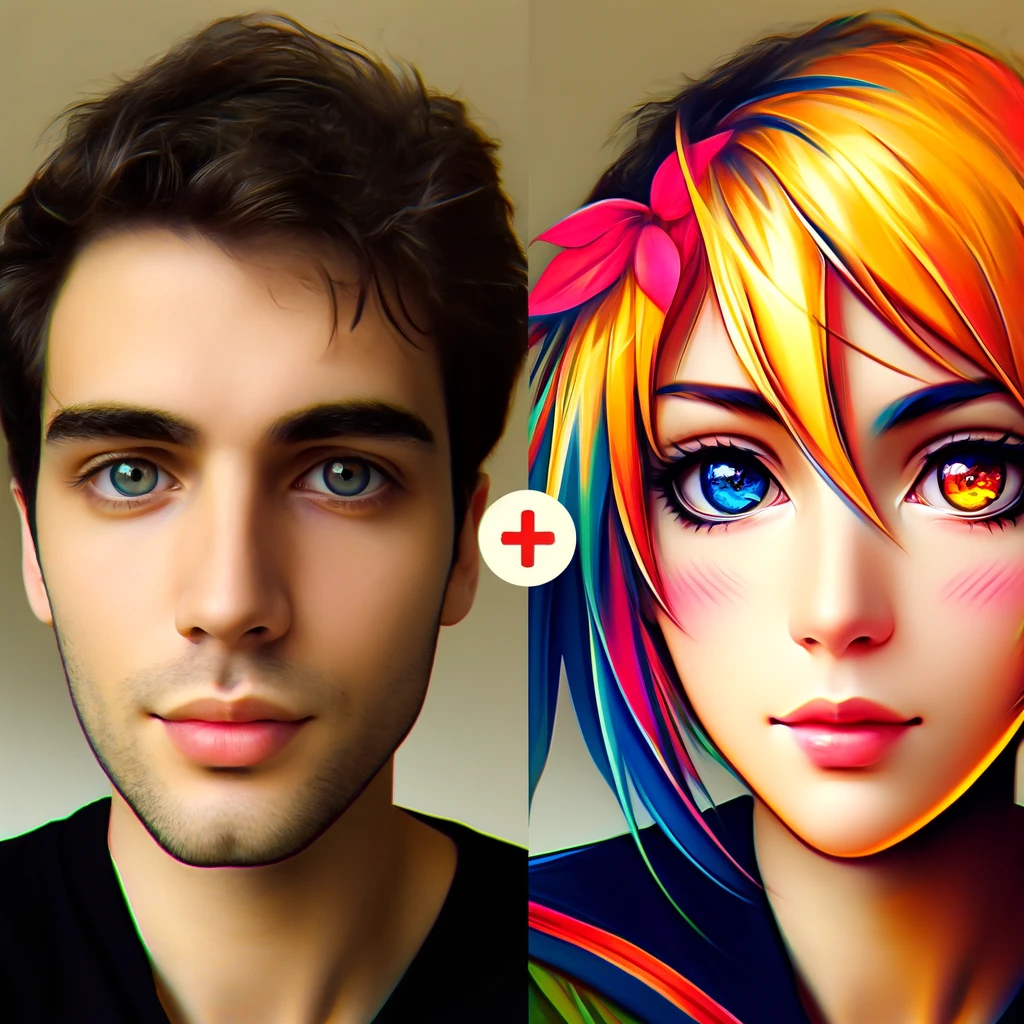**



# **ABSTRACT**

 Implementing a Generative Adversarial Network (GAN) using the PyTorch library to generate anime-style images. The notebook includes detailed steps to design and train a GAN model, as well as visualizations of the generated images to evaluate the model's performance. This project aims to explore the capabilities of GANs in creating high-quality, diverse anime images from a trained dataset, demonstrating both the potential and challenges of neural networks in artistic image generation

# **About the Dataset**

* 3400 women faces in trainA
* 3400 anime faces in trainB
* 100 women faces in testA
* 100 anime faces in testB

### **Importing Libraries**

In [1]:
!pip install torchsummary

!pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 13.4 MB/s eta 0:00:00
  Attempting uninstall: google-auth-httplib2
    Found existing installation: google-auth-httplib2 0.1.1
    Uninstalling google-auth-httplib2-0.1.1:
      Successfully uninstalled google-auth-httplib2-0.1.1
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 2.84.0
    Uninstalling google-api-python-client-2.84.0:
      Successfully uninstalled google-api-python-client-2.84.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
import datetime
import matplotlib.pyplot as plt

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

torch.manual_seed(1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 128

## **Load Dataset**

In [5]:
train_transform = transforms.Compose([transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
train_dataset = datasets.ImageFolder(root='/content/drive/My Drive/CelebA/selfitoanime', transform=train_transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# **Visualizing Datasets in Batches**

In [6]:
def show_images(images):
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach(), nrow=22).permute(1, 2, 0))

def show_batch(dl):
    for images, _ in dl:
        show_images(images)
        break

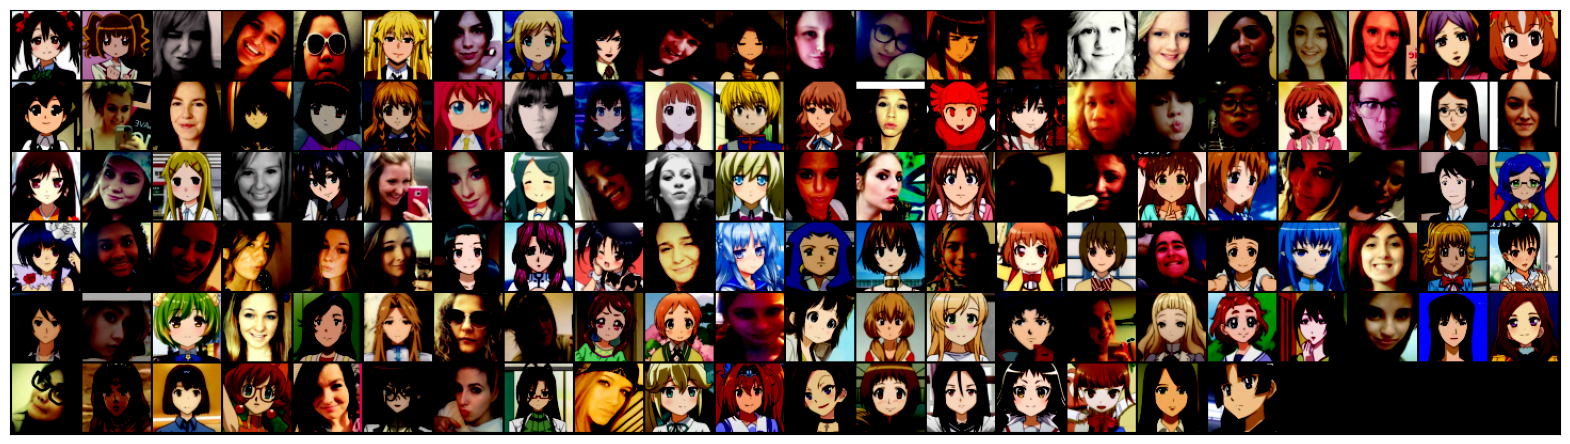

In [7]:
show_batch(train_loader)

# **Creating DCGAN**

* The **image_shape** outlines the dimensions of RGB images, crucial for defining the input layer of the network.

* **image_dim** provides the total number of image elements, used when flattening images for certain model architectures.

*  **latent_dim** refers to the size of the latent space in generative models, which influences how effectively the model can learn and generate diverse images. This setup ensures proper handling and processing of image data in neural network operations.

In [8]:
image_shape = (3, 64, 64)
image_dim = int(np.prod(image_shape))
latent_dim = 100

# **Initializing Weights**

* All the convolution-layer weights are initialized from a zero-centered normal distribution, with a standard deviation of 0.02.
* The batch-normalization layer weights are initialized with a normal distribution, having mean 1 and a standard deviation of 0.02. The bias is initialized with zeros.

This method ensures that the initial outputs of these layers are normalized properly, aiding in faster and more stable convergence during training.

In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

# **Generator**

In the context of Generative Adversarial Networks (GANs), a generator is a type of neural network that is designed to generate new data instances that are similar to the training data. Its role is to create convincing "fake" outputs, competing against a discriminator network that tries to distinguish these fakes from real examples. The generator learns to produce more accurate and realistic data as it trains, continually improving until the discriminator can no longer easily tell the difference between real and generated samples. This process enables the production of new, synthetic data instances that can be very similar to authentic data in the dataset.

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        output = self.main(input)
        return output

In [11]:
generator = Generator().to(device)
generator.apply(weights_init)
print(generator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


It describes the architecture of a Generator within a Generative Adversarial Network (GAN). It uses ConvTranspose2d layers to upscale the input from a latent space to an image, interspersed with BatchNorm2d for normalization and ReLU for non-linearity. The architecture progressively increases the resolution of the generated image through each layer, culminating in a Tanh layer that outputs the final image with pixel values normalized between -1 and 1. Each layer is carefully designed to gradually form a detailed and structured output image from a compact latent code.

In [12]:
summary(generator, (100,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

The architecture summary for the Generator model shows how each layer contributes to forming a final image from a low-dimensional latent space. Starting with a dense representation, the model upscales through several ConvTranspose2d layers, each followed by BatchNorm2d and ReLU activations, which enhance stability and non-linearity.

The model expands from a compact 4x4 representation to a full 64x64 RGB image, finalizing the output with a Tanh activation to normalize pixel values. The total trainable parameters amount to 3,576,704, reflecting the model's complexity and capacity.

# **Descriminator**

In a Generative Adversarial Network (GAN), the discriminator is a neural network that serves as the counterpart to the generator. Its main function is to differentiate between real images (from the dataset) and fake images (produced by the generator). It essentially acts as a classifier, receiving an image as input and outputting a probability that the image is real. This feedback helps the generator improve, as it strives to produce images that the discriminator will classify as real, enhancing the realism and quality of the generated images.

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
            nn.Flatten()
        )

    def forward(self, input):
        output = self.main(input)
        return output

In [14]:
discriminator = Discriminator().to(device)
discriminator.apply(weights_init)
print(discriminator)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
    (13): Flatten(start_dim=1, end_d

The Discriminator architecture described features a sequence of Conv2D layers with increasing complexity, each followed by a LeakyReLU activation function for non-linearity, and some followed by BatchNorm2d for normalization. The Conv2D layers serve to downsample the image, extracting features at each layer.

The final Conv2d layer reduces the feature map to a single value, followed by a Sigmoid function to output a probability indicating whether the input is a real or a fake image. The Flatten layer then converts the 2D output to a 1D tensor for final classification.

In [15]:
summary(discriminator, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,192
          Sigmoid-13              [-1, 1, 1, 1]               0
          Flatten-14                   

The architecture summary outlines the discriminator model in a GAN. It sequentially applies convolutional operations to reduce spatial dimensions and increase depth, capturing more complex features. The model has over 2.7 million trainable parameters, indicating its capacity to perform the detailed task of distinguishing real images from fakes.

The final sigmoid function outputs a probability, predicting the authenticity of the input image. This compact summary provides insights into the model's structure and potential computational requirements.

### **Binary Cross-Entropy Loss for Adversarial Training**

A common loss function used in binary classification problems. In the context of GANs, it's used to measure how well the discriminator can distinguish between real and fake images, and how well the generator can create believable fakes. It compares the discriminator's predictions to the true labels (real or fake) and penalizes the predictions that are far from the actual labels

In [16]:
adversarial_loss = nn.BCELoss()

## **The generator_loss function is fed two parameters:**

* **fake_output:** Output predictions from the discriminator, when fed generator-produced images.

* **label:** Ground truth labels (1), for you would like the generator to fool the discriminator and produce real images. Hence, the labels would be one.

In [17]:
def generator_loss(fake_output, label):
    gen_loss = adversarial_loss(fake_output, label)
    return gen_loss

## **The discriminator loss has:**
* real (original images) output predictions, ground truth label as 1
* fake (generated images) output predictions, ground truth label as 0.

In [18]:
def discriminator_loss(output, label):
    disc_loss = adversarial_loss(output, label)
    return disc_loss

In [19]:
fixed_noise = torch.randn(128, latent_dim, 1, 1, device=device)
real_label = 1
fake_label = 0

In [20]:
learning_rate = 0.0002
G_optimizer = optim.Adam(generator.parameters(), lr = learning_rate, betas=(0.5, 0.999))
D_optimizer = optim.Adam(discriminator.parameters(), lr = learning_rate, betas=(0.5, 0.999))

# **Training Network**

An iterative processes where the generator tries to produce data that the discriminator cannot distinguish from real data, and the discriminator tries to get better at telling the difference. It's a dynamic tug-of-war that sharpens the generator's ability to create realistic outputs. The adversarial loss function guides this training by penalizing the generator for outputs that the discriminator can easily classify as fake and penalizing the discriminator for incorrectly classifying real data as fake or vice versa.

This process continues until the generator produces data indistinguishable from actual data, at which point the discriminator's loss should be about 0.5, indicating an inability to differentiate between real and fake.

In [21]:
num_epochs = 100
D_loss_plot, G_loss_plot = [], []
for epoch in range(1, num_epochs+1):

    D_loss_list, G_loss_list = [], []

    for index, (real_images, _) in enumerate(train_loader):
        D_optimizer.zero_grad()
        real_images = real_images.to(device)

        real_target = Variable(torch.ones(real_images.size(0)).to(device))
        fake_target = Variable(torch.zeros(real_images.size(0)).to(device))

        real_target = real_target.unsqueeze(1)
        fake_target = fake_target.unsqueeze(1)

        D_real_loss = discriminator_loss(discriminator(real_images), real_target)
        D_real_loss.backward()

        noise_vector = torch.randn(real_images.size(0), latent_dim, 1, 1, device=device)
        noise_vector = noise_vector.to(device)

        generated_image = generator(noise_vector)
        output = discriminator(generated_image.detach())
        D_fake_loss = discriminator_loss(output,  fake_target)

        D_fake_loss.backward()

        D_total_loss = D_real_loss + D_fake_loss
        D_loss_list.append(D_total_loss)

        D_optimizer.step()


        G_optimizer.zero_grad()
        G_loss = generator_loss(discriminator(generated_image), real_target)
        G_loss_list.append(G_loss)

        G_loss.backward()
        G_optimizer.step()


    print('Epoch: [%d/%d]: D_loss: %.3f, G_loss: %.3f' % (
            (epoch), num_epochs, torch.mean(torch.FloatTensor(D_loss_list)),\
             torch.mean(torch.FloatTensor(G_loss_list))))

    D_loss_plot.append(torch.mean(torch.FloatTensor(D_loss_list)))
    G_loss_plot.append(torch.mean(torch.FloatTensor(G_loss_list)))


Epoch: [1/3]: D_loss: 0.642, G_loss: 13.279
Epoch: [2/3]: D_loss: 0.702, G_loss: 10.351
Epoch: [3/3]: D_loss: 0.621, G_loss: 6.329


# **Outputing Results**

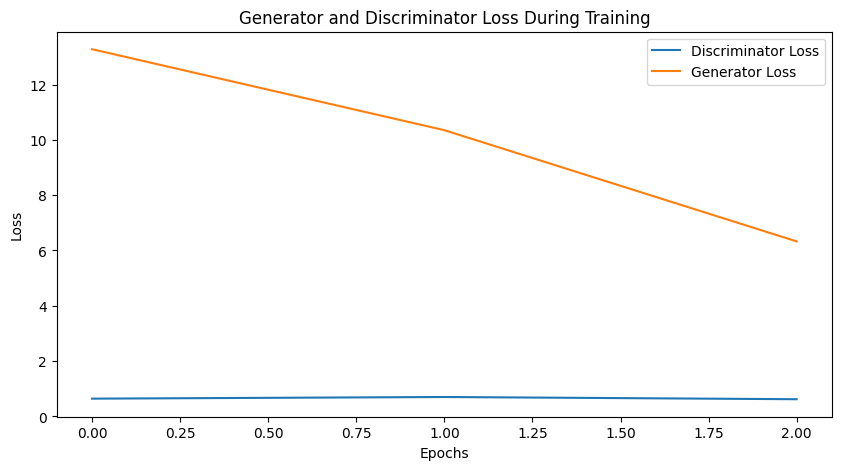

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(D_loss_plot, label="Discriminator Loss")
plt.plot(G_loss_plot, label="Generator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

The graph shows the training process of a Generative Adversarial Network, plotting both discriminator and generator loss over a number of epochs (If increased epochs count , this graph would be different). Ideally, the discriminator loss should oscillate or decrease over time, while the generator loss should gradually decrease as it learns to generate more convincing images. In this graph, both losses are decreasing, which could indicate that the generator is improving its ability to create images that the discriminator is more frequently classifying as real.

### **Evaluate the generator's performance by generating a fixed set of images**

In [32]:
fixed_noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)  # Fixed noise vector

with torch.no_grad():
    generator.eval()  # Set the generator to evaluation mode
    final_generated_images = generator(fixed_noise).detach().cpu()

img_grid_final = make_grid(final_generated_images, padding=2, normalize=True)
save_image(img_grid_final, "final_generated_images.png", nrow=batch_size)

# Optionally, print model's state dict or save the model
print("Final model state:", generator.state_dict())
torch.save(generator.state_dict(), 'generator_final.pth')
torch.save(discriminator.state_dict(), 'discriminator_final.pth')

Final model state: OrderedDict([('main.0.weight', tensor([[[[ 3.7497e-02,  2.4415e-02,  1.1582e-02, -2.9092e-02],
          [ 2.1128e-02, -3.5865e-03,  6.0346e-03,  3.3682e-02],
          [ 5.5362e-03,  2.5946e-02,  1.0002e-05,  2.1198e-02],
          [ 1.0307e-02, -3.7770e-02, -7.0795e-03, -4.7216e-02]],

         [[ 3.0094e-02, -4.4829e-02,  2.8329e-02,  2.0371e-02],
          [ 5.1639e-02,  3.3367e-02, -2.4491e-02, -1.4603e-02],
          [ 3.6222e-02,  2.6749e-02, -1.3267e-02,  2.8863e-02],
          [ 1.1875e-02, -1.2089e-02, -4.9169e-02, -2.6234e-02]],

         [[ 2.7005e-02,  4.0394e-02,  3.6654e-03, -1.3900e-02],
          [ 1.0959e-02,  3.8909e-02, -1.1789e-02,  1.3173e-02],
          [ 2.0436e-02,  6.2439e-02,  3.9419e-02, -4.7844e-02],
          [ 8.8795e-04, -1.3432e-02,  4.9277e-03,  2.8690e-03]],

         ...,

         [[ 3.2590e-02,  1.2211e-02,  2.0656e-02, -3.7557e-02],
          [-9.8419e-03,  5.2048e-03,  8.0659e-03, -2.0474e-02],
          [-2.7756e-02,  8.6602e-

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import torch

output = torch.tensor(final_generated_images)

# Convert to numpy and scale to [0, 1] for displaying
image_data = output.numpy()
image_data = (image_data - image_data.min()) / (image_data.max() - image_data.min())


<ipython-input-44-b1e4633fa46b>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = torch.tensor(final_generated_images)


(128, 3, 64, 64)
Transposed image shape: (64, 64, 3)


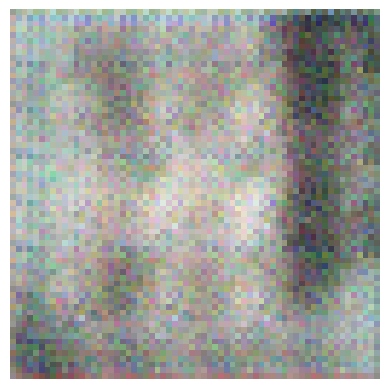

Transposed image shape: (64, 64, 3)


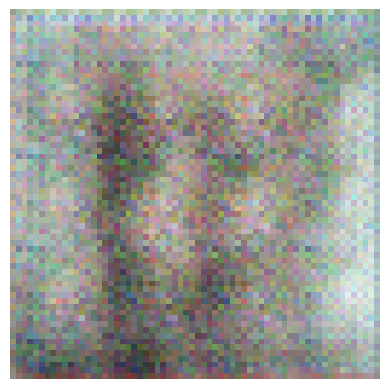

Transposed image shape: (64, 64, 3)


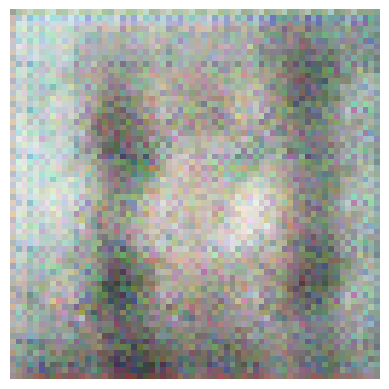

Transposed image shape: (64, 64, 3)


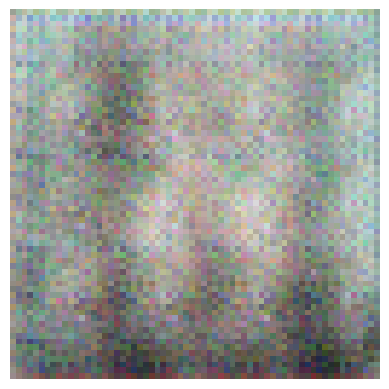

Transposed image shape: (64, 64, 3)


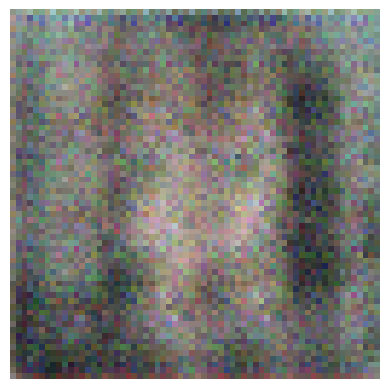

Transposed image shape: (64, 64, 3)


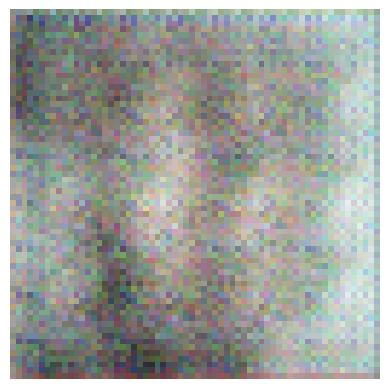

Transposed image shape: (64, 64, 3)


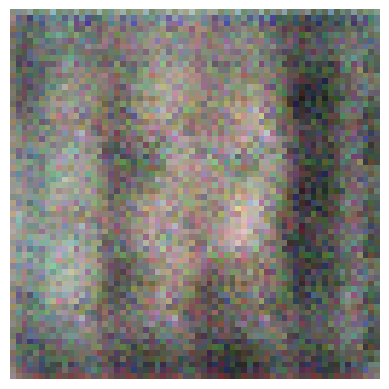

Transposed image shape: (64, 64, 3)


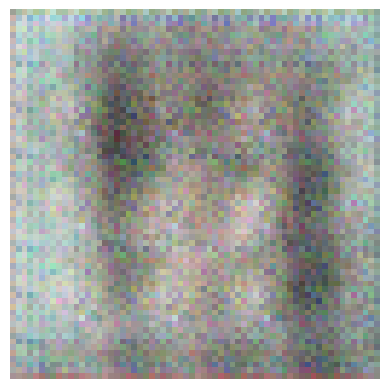

Transposed image shape: (64, 64, 3)


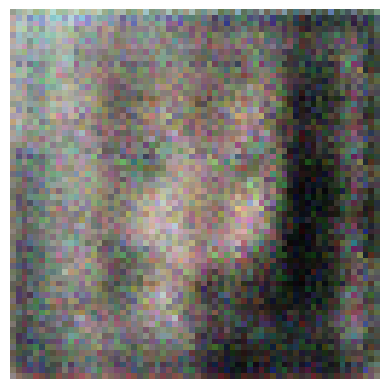

Transposed image shape: (64, 64, 3)


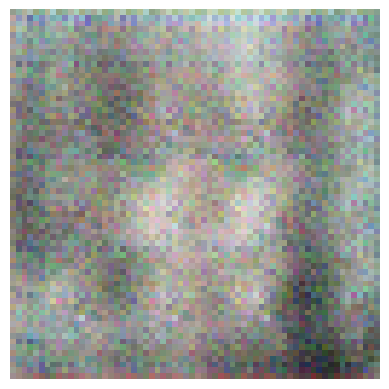

Transposed image shape: (64, 64, 3)


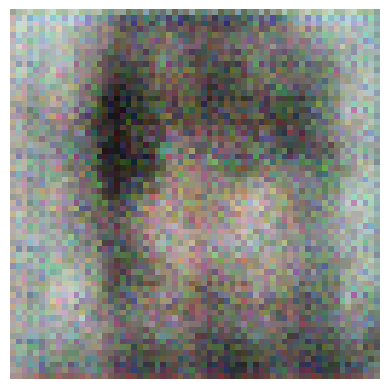

Transposed image shape: (64, 64, 3)


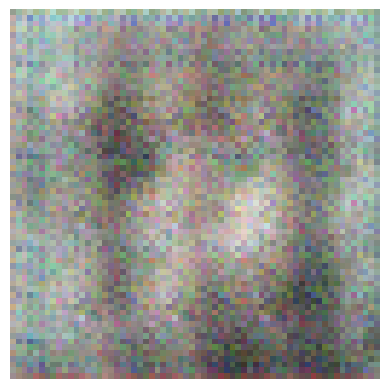

Transposed image shape: (64, 64, 3)


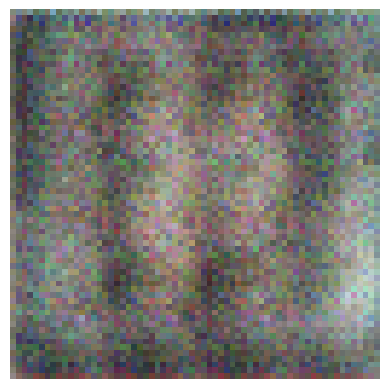

Transposed image shape: (64, 64, 3)


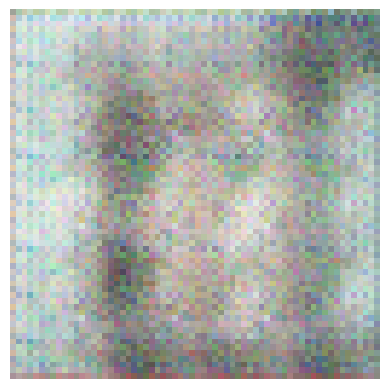

Transposed image shape: (64, 64, 3)


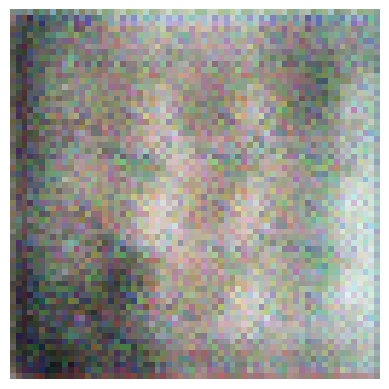

Transposed image shape: (64, 64, 3)


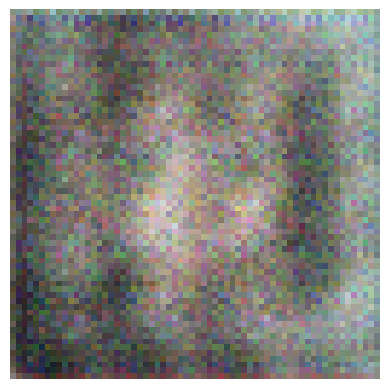

Transposed image shape: (64, 64, 3)


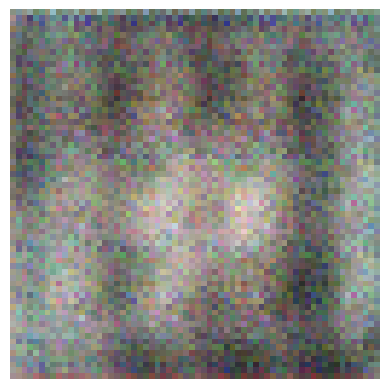

Transposed image shape: (64, 64, 3)


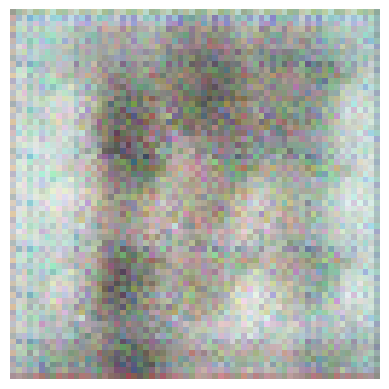

Transposed image shape: (64, 64, 3)


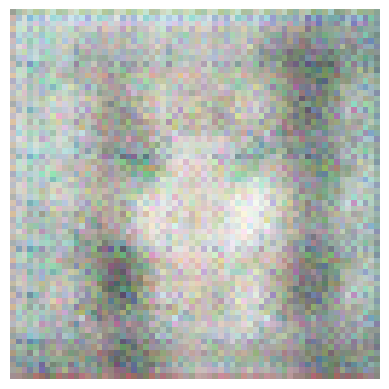

Transposed image shape: (64, 64, 3)


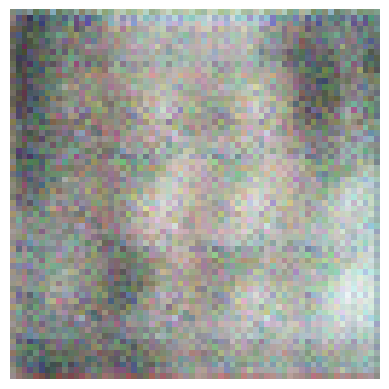

Transposed image shape: (64, 64, 3)


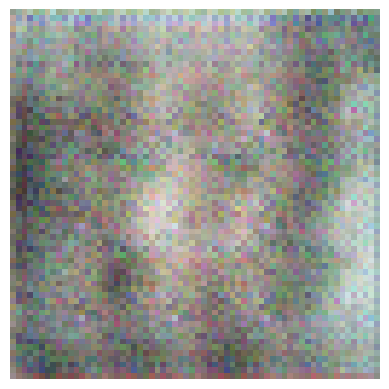

Transposed image shape: (64, 64, 3)


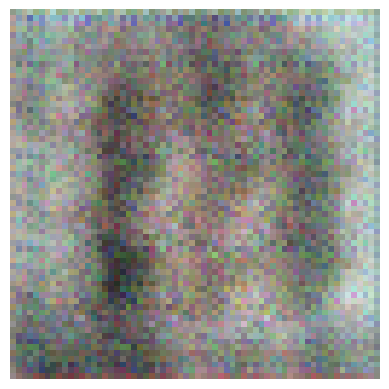

Transposed image shape: (64, 64, 3)


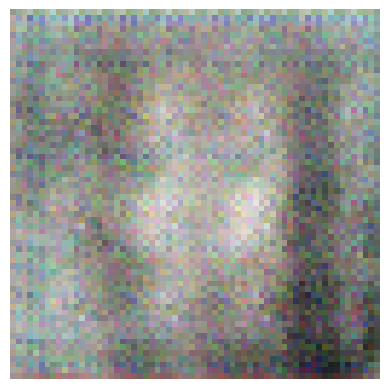

Transposed image shape: (64, 64, 3)


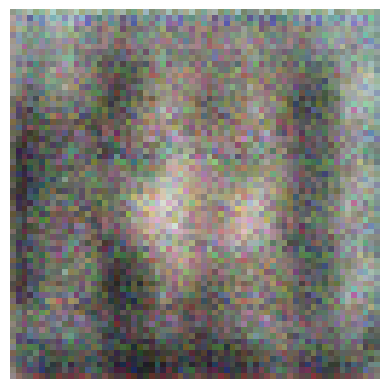

Transposed image shape: (64, 64, 3)


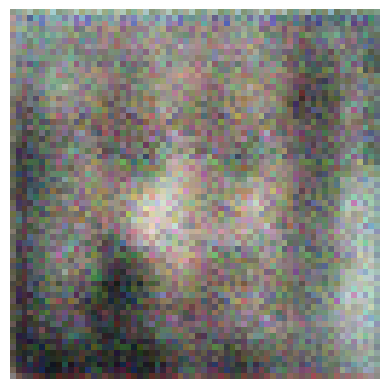

Transposed image shape: (64, 64, 3)


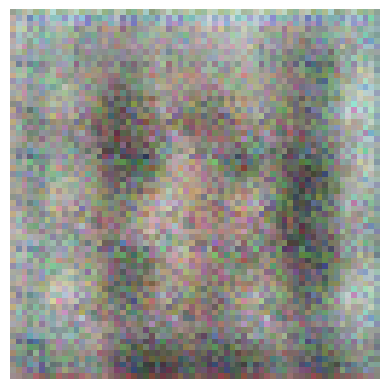

Transposed image shape: (64, 64, 3)


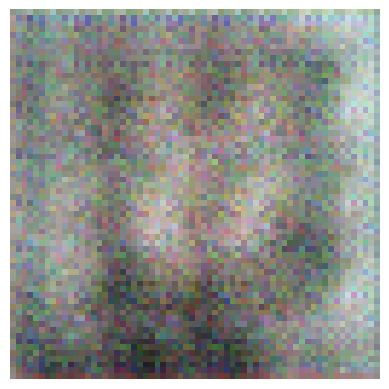

Transposed image shape: (64, 64, 3)


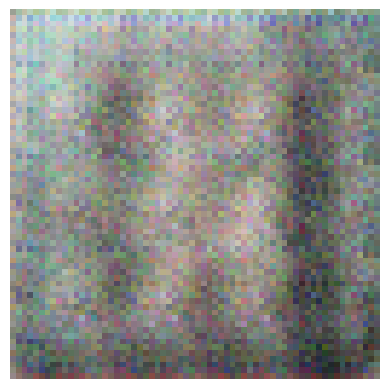

Transposed image shape: (64, 64, 3)


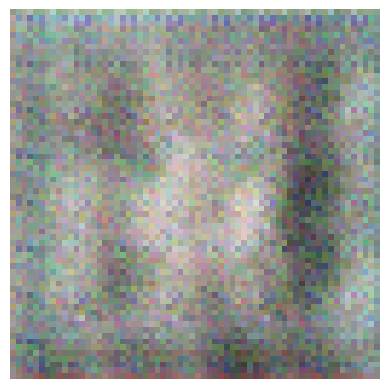

Transposed image shape: (64, 64, 3)


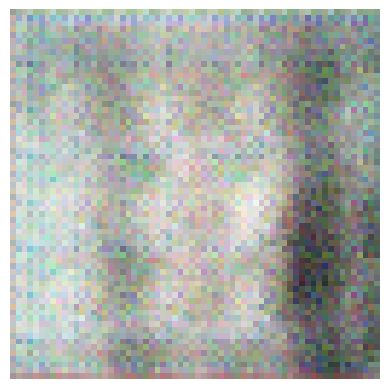

Transposed image shape: (64, 64, 3)


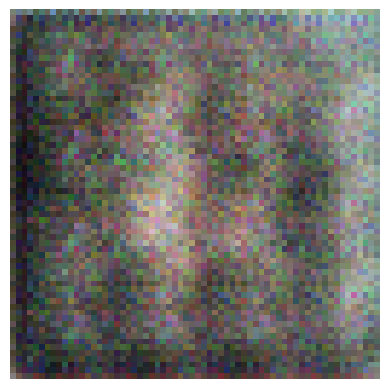

Transposed image shape: (64, 64, 3)


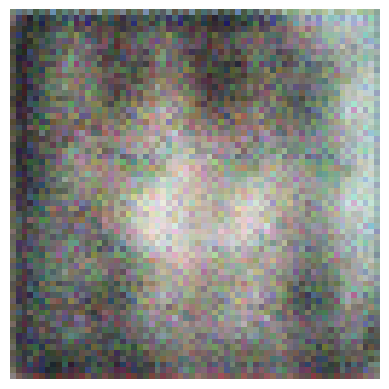

Transposed image shape: (64, 64, 3)


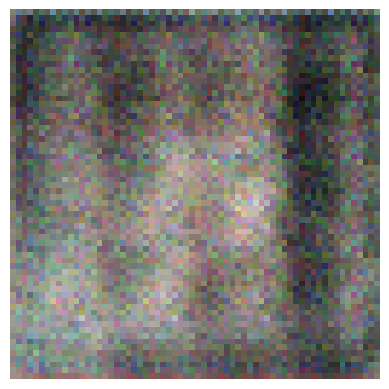

Transposed image shape: (64, 64, 3)


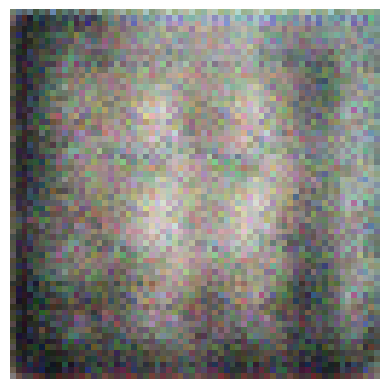

Transposed image shape: (64, 64, 3)


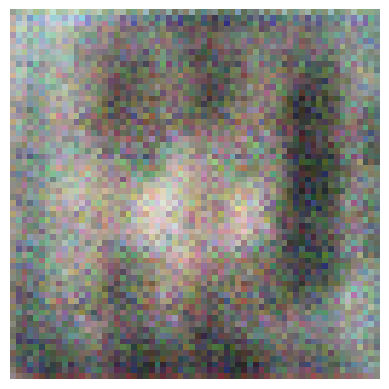

Transposed image shape: (64, 64, 3)


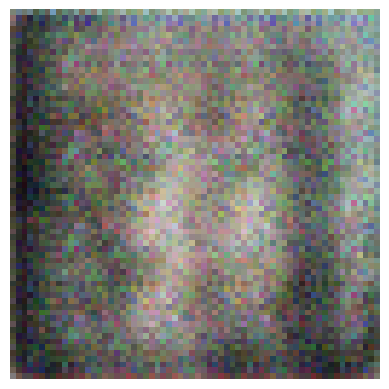

Transposed image shape: (64, 64, 3)


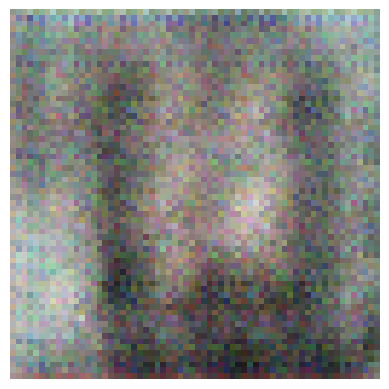

Transposed image shape: (64, 64, 3)


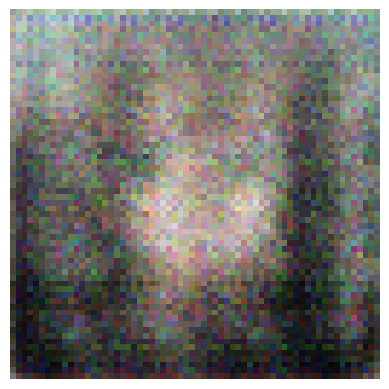

Transposed image shape: (64, 64, 3)


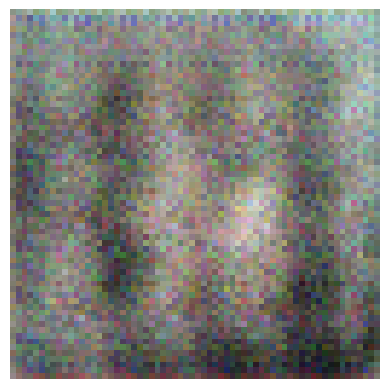

Transposed image shape: (64, 64, 3)


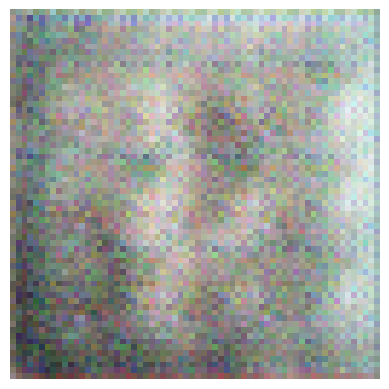

Transposed image shape: (64, 64, 3)


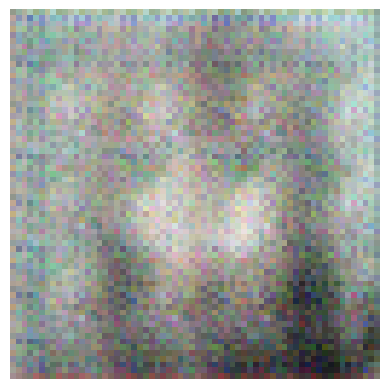

Transposed image shape: (64, 64, 3)


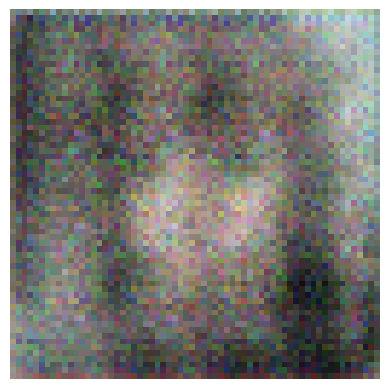

Transposed image shape: (64, 64, 3)


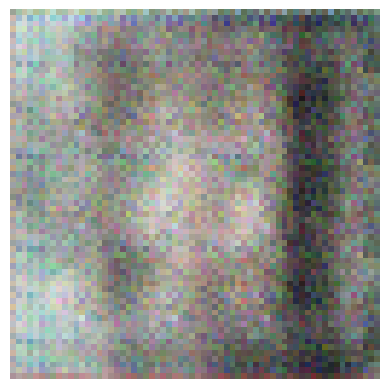

Transposed image shape: (64, 64, 3)


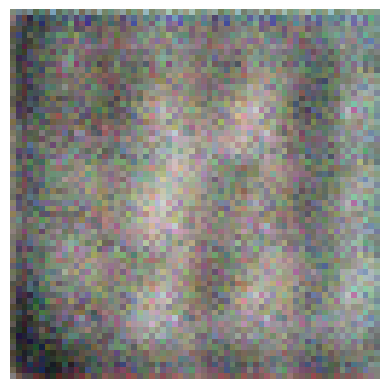

Transposed image shape: (64, 64, 3)


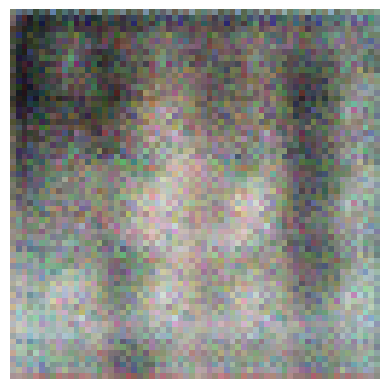

Transposed image shape: (64, 64, 3)


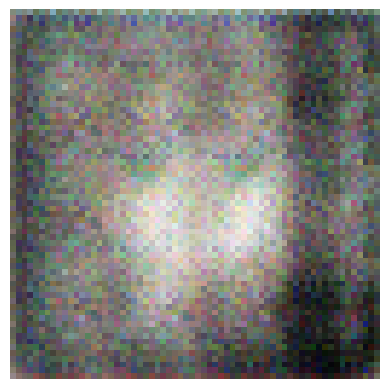

Transposed image shape: (64, 64, 3)


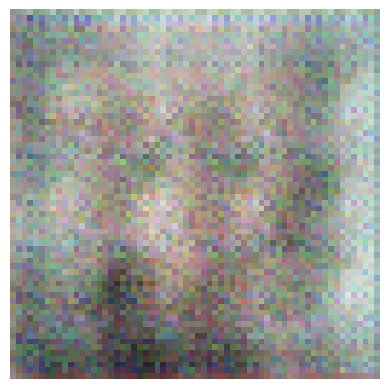

Transposed image shape: (64, 64, 3)


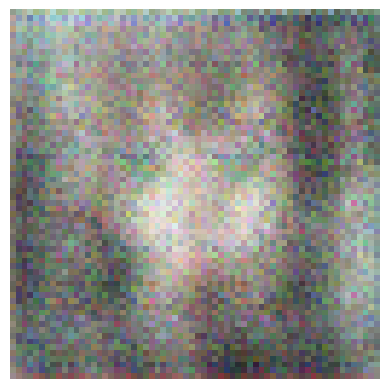

Transposed image shape: (64, 64, 3)


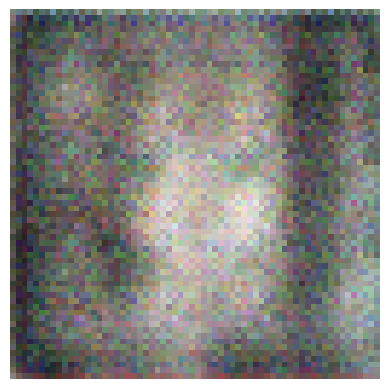

Transposed image shape: (64, 64, 3)


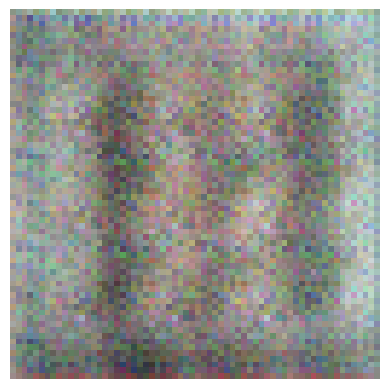

Transposed image shape: (64, 64, 3)


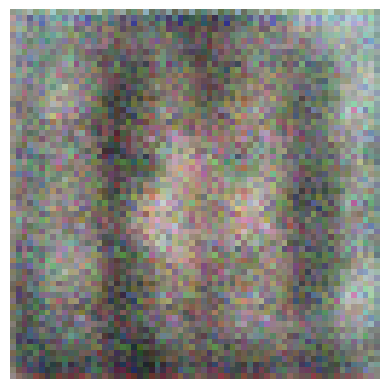

Transposed image shape: (64, 64, 3)


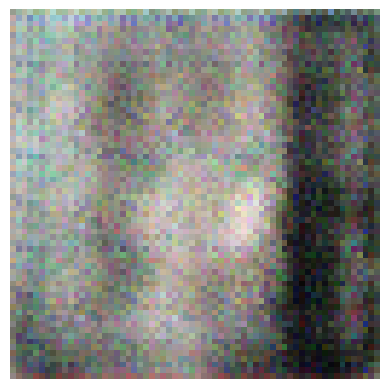

Transposed image shape: (64, 64, 3)


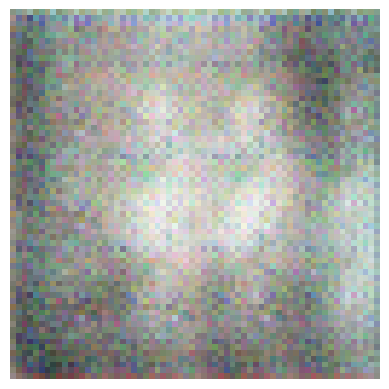

Transposed image shape: (64, 64, 3)


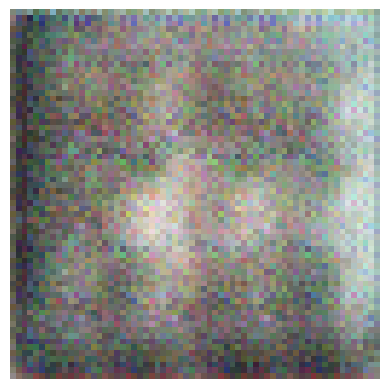

Transposed image shape: (64, 64, 3)


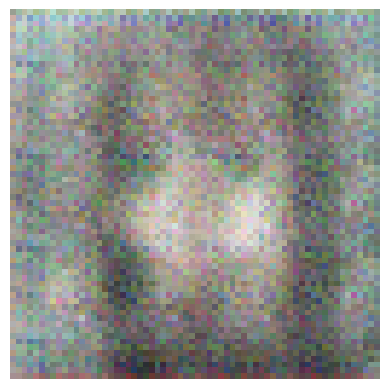

Transposed image shape: (64, 64, 3)


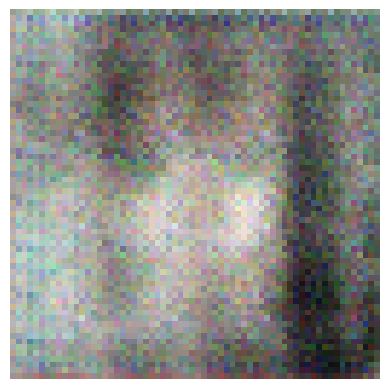

Transposed image shape: (64, 64, 3)


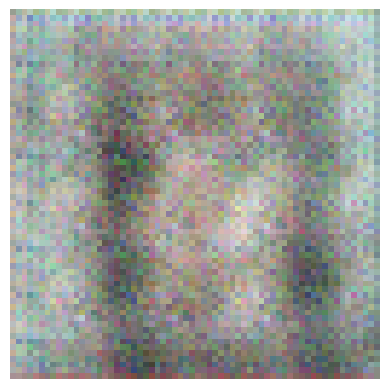

Transposed image shape: (64, 64, 3)


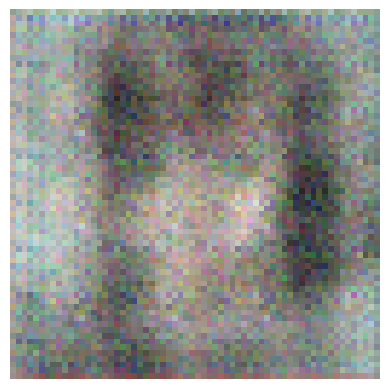

Transposed image shape: (64, 64, 3)


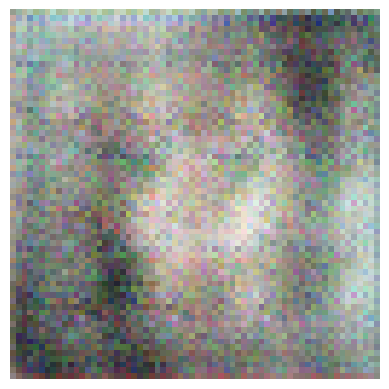

Transposed image shape: (64, 64, 3)


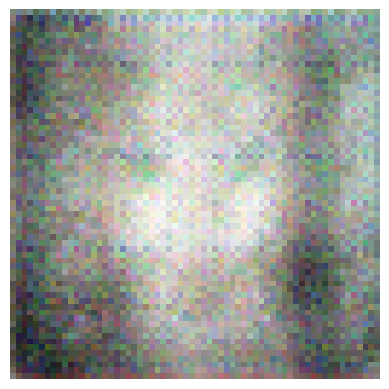

Transposed image shape: (64, 64, 3)


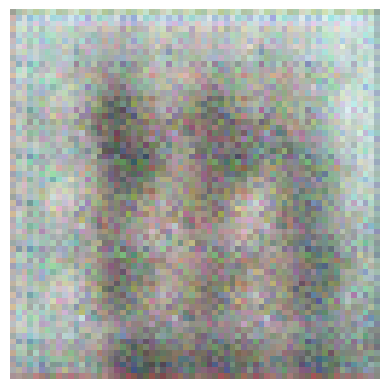

Transposed image shape: (64, 64, 3)


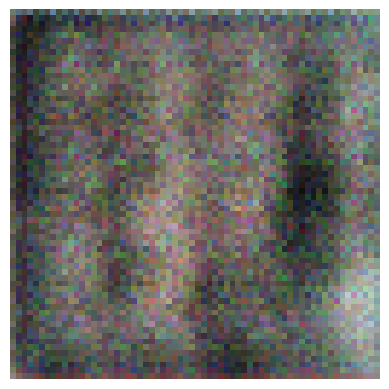

Transposed image shape: (64, 64, 3)


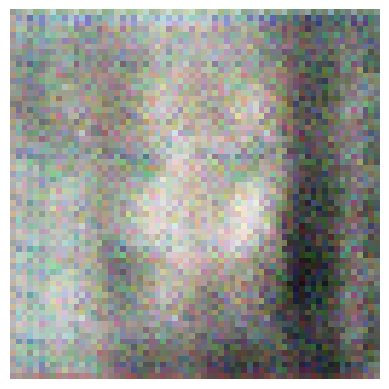

Transposed image shape: (64, 64, 3)


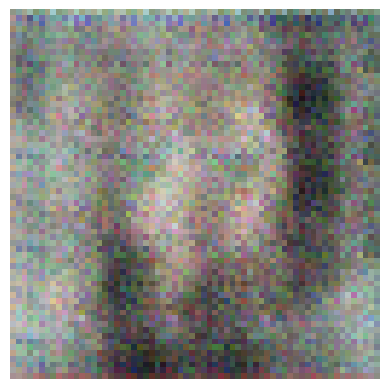

Transposed image shape: (64, 64, 3)


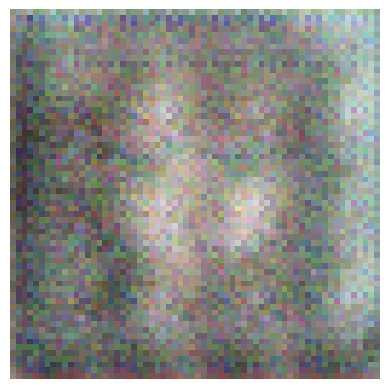

Transposed image shape: (64, 64, 3)


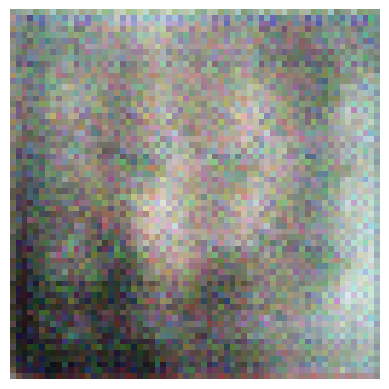

Transposed image shape: (64, 64, 3)


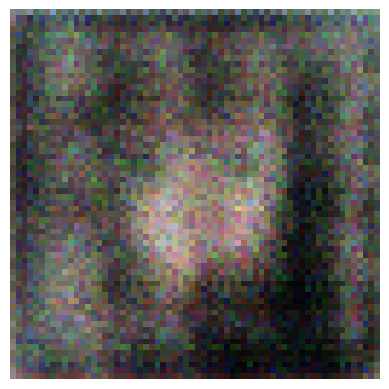

Transposed image shape: (64, 64, 3)


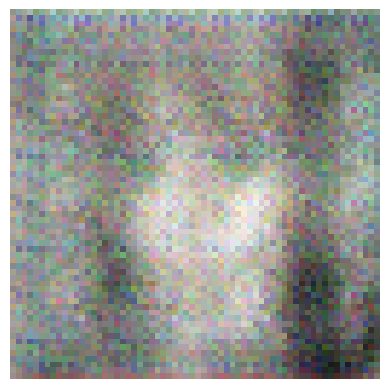

Transposed image shape: (64, 64, 3)


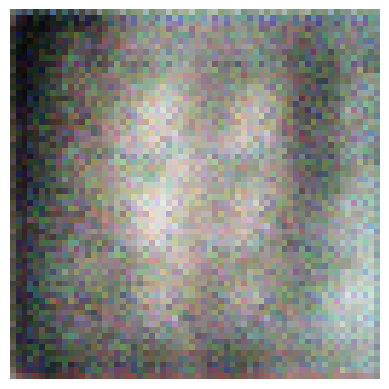

Transposed image shape: (64, 64, 3)


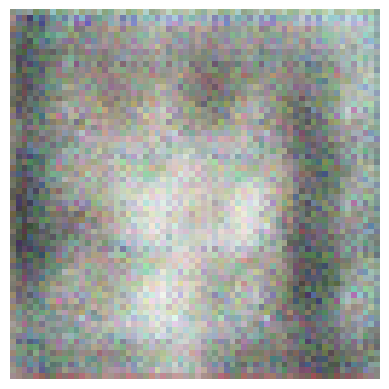

Transposed image shape: (64, 64, 3)


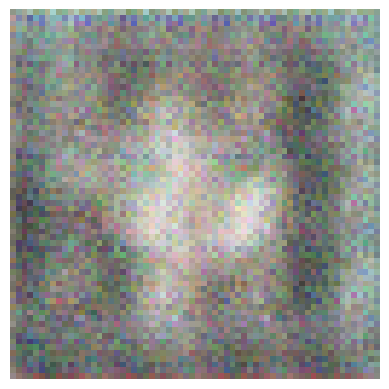

Transposed image shape: (64, 64, 3)


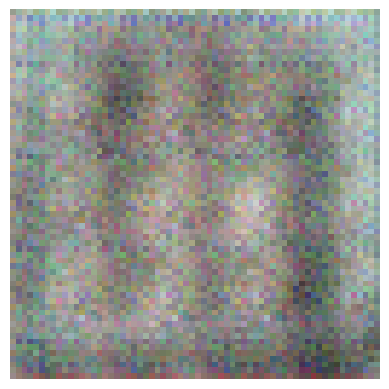

Transposed image shape: (64, 64, 3)


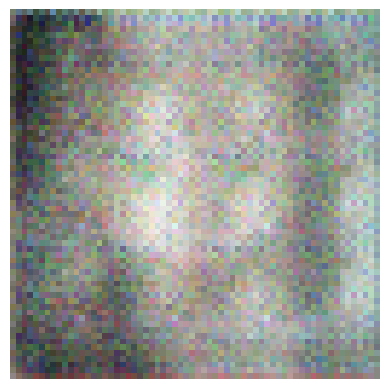

Transposed image shape: (64, 64, 3)


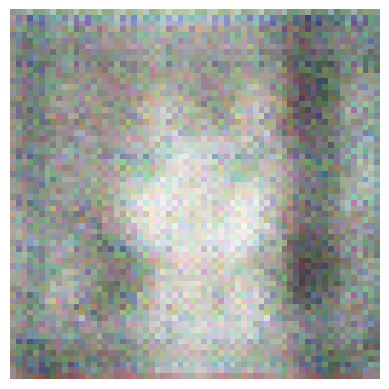

Transposed image shape: (64, 64, 3)


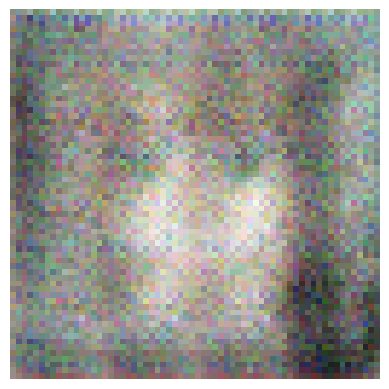

Transposed image shape: (64, 64, 3)


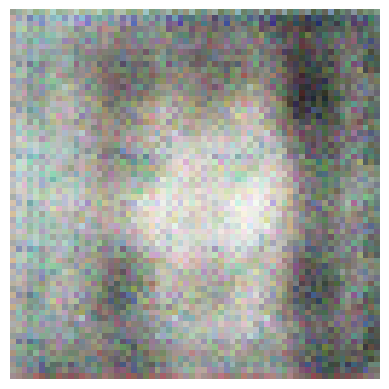

Transposed image shape: (64, 64, 3)


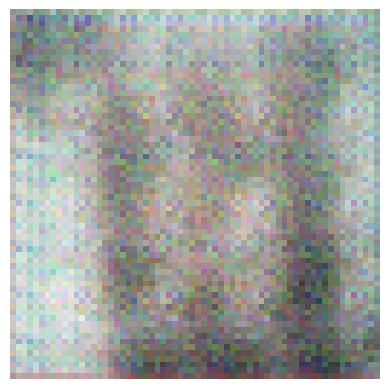

Transposed image shape: (64, 64, 3)


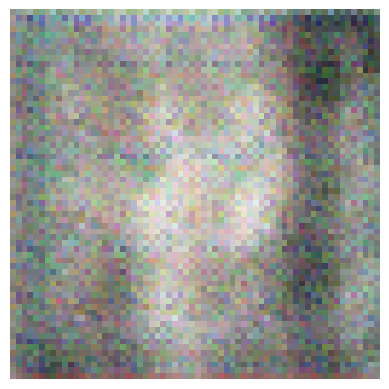

Transposed image shape: (64, 64, 3)


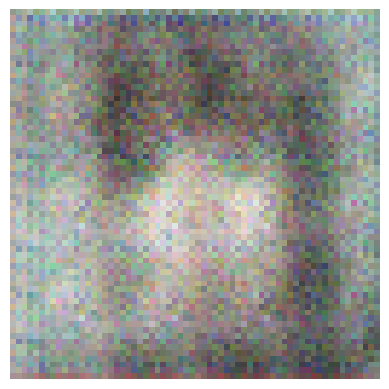

Transposed image shape: (64, 64, 3)


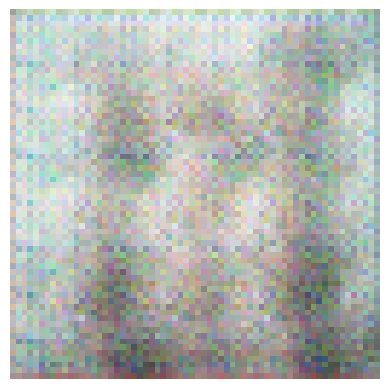

Transposed image shape: (64, 64, 3)


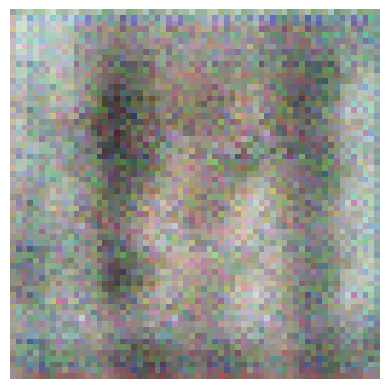

Transposed image shape: (64, 64, 3)


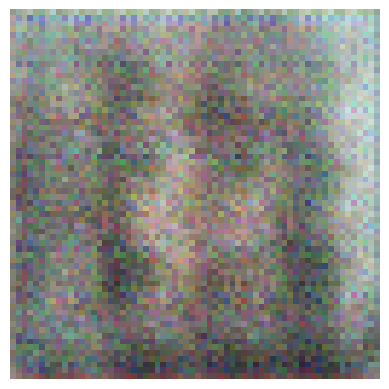

Transposed image shape: (64, 64, 3)


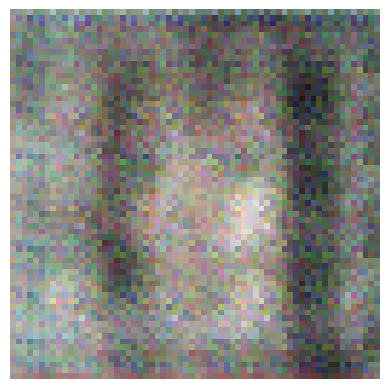

Transposed image shape: (64, 64, 3)


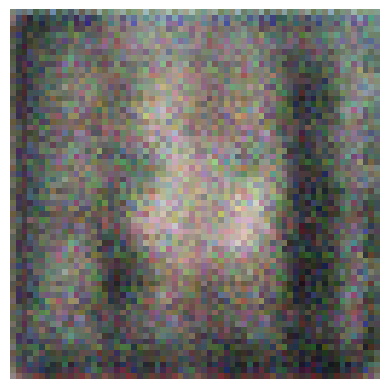

Transposed image shape: (64, 64, 3)


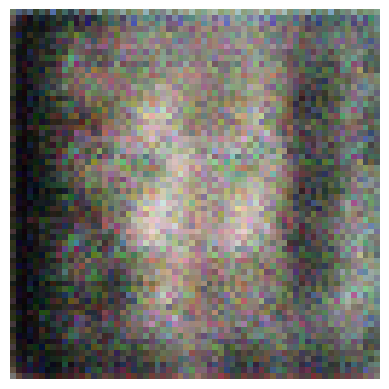

Transposed image shape: (64, 64, 3)


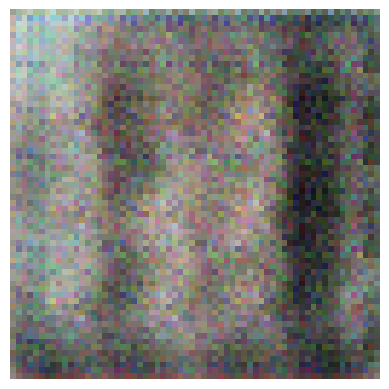

Transposed image shape: (64, 64, 3)


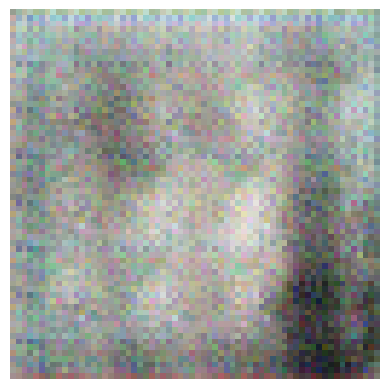

Transposed image shape: (64, 64, 3)


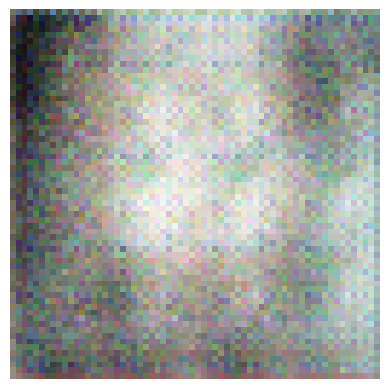

Transposed image shape: (64, 64, 3)


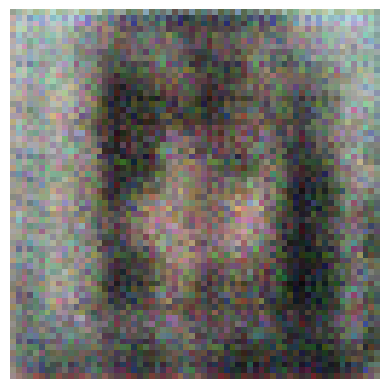

Transposed image shape: (64, 64, 3)


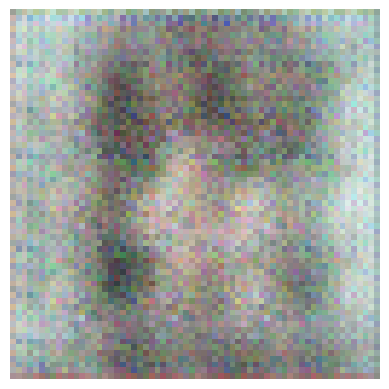

Transposed image shape: (64, 64, 3)


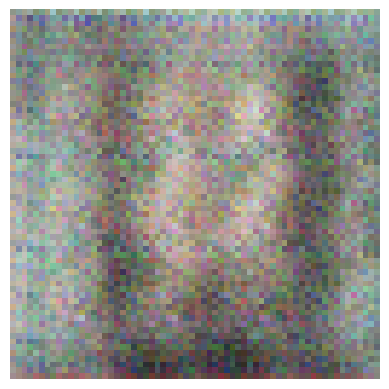

Transposed image shape: (64, 64, 3)


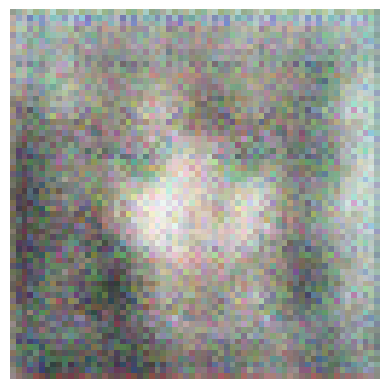

Transposed image shape: (64, 64, 3)


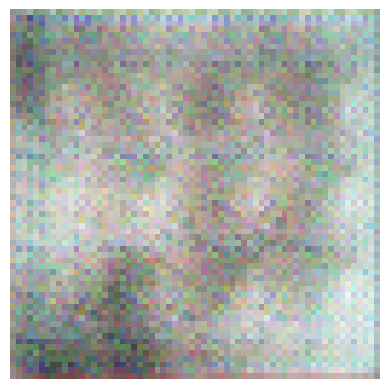

Transposed image shape: (64, 64, 3)


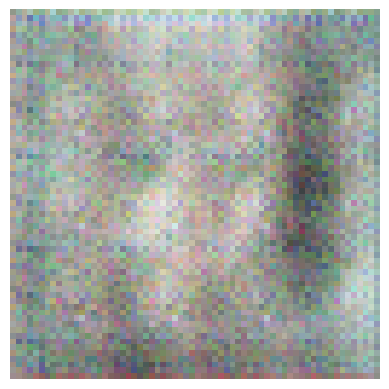

Transposed image shape: (64, 64, 3)


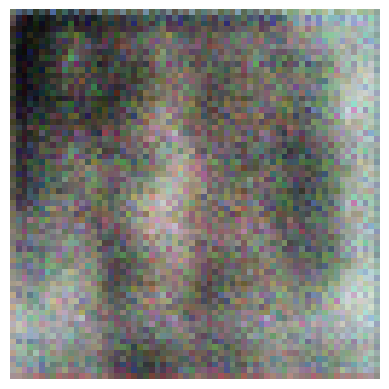

Transposed image shape: (64, 64, 3)


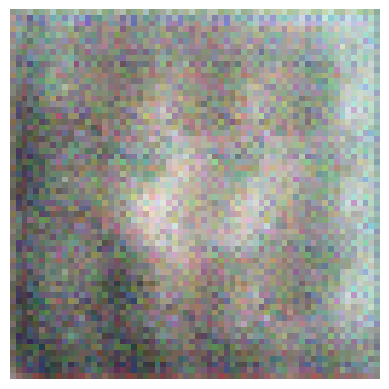

Transposed image shape: (64, 64, 3)


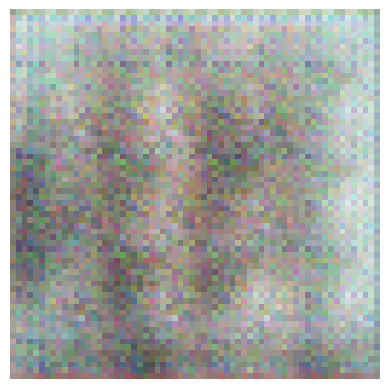

Transposed image shape: (64, 64, 3)


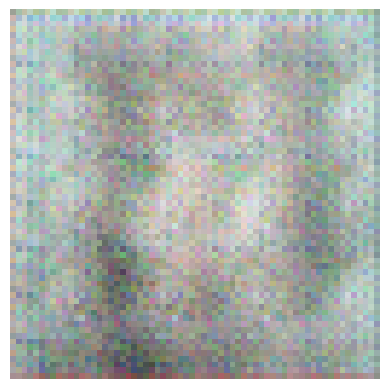

Transposed image shape: (64, 64, 3)


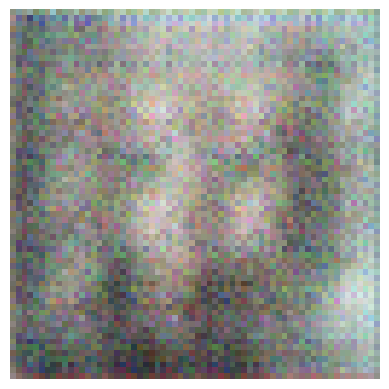

Transposed image shape: (64, 64, 3)


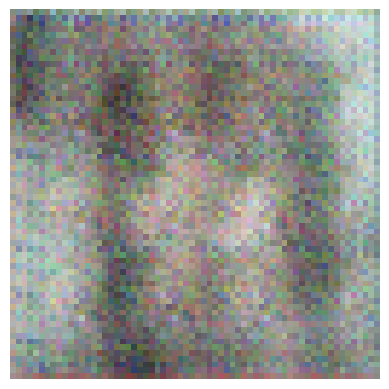

Transposed image shape: (64, 64, 3)


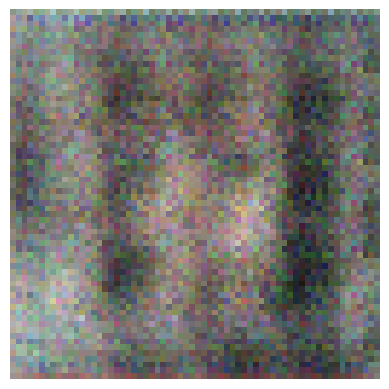

Transposed image shape: (64, 64, 3)


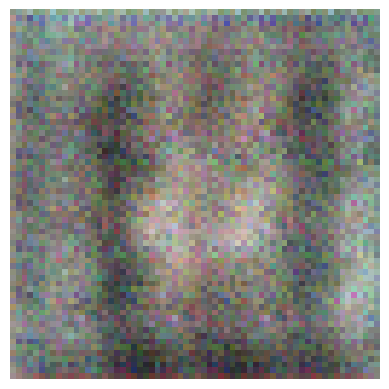

Transposed image shape: (64, 64, 3)


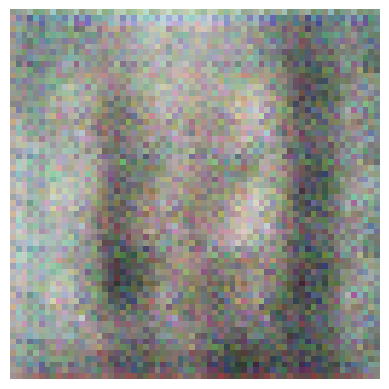

Transposed image shape: (64, 64, 3)


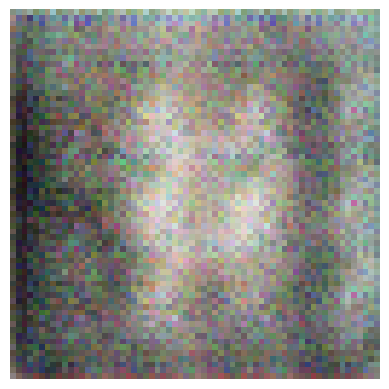

Transposed image shape: (64, 64, 3)


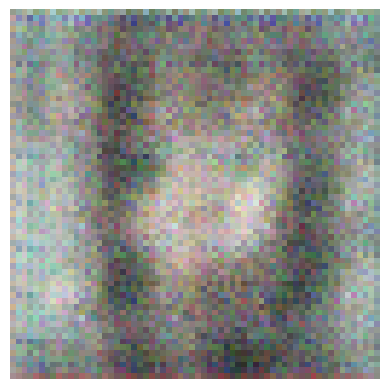

Transposed image shape: (64, 64, 3)


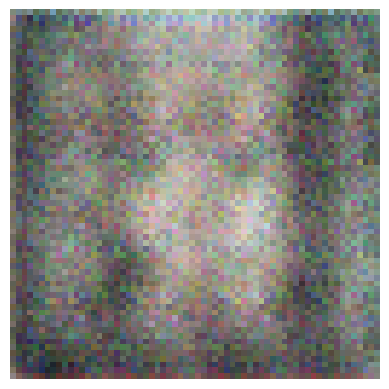

Transposed image shape: (64, 64, 3)


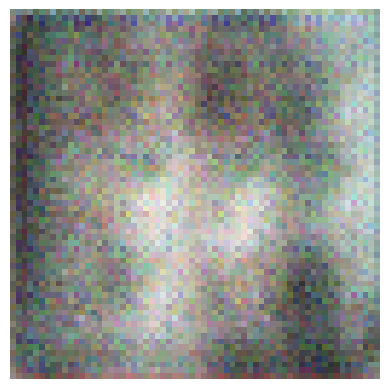

Transposed image shape: (64, 64, 3)


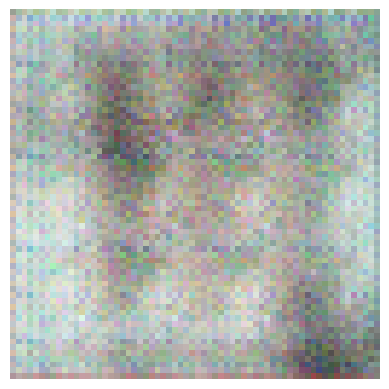

Transposed image shape: (64, 64, 3)


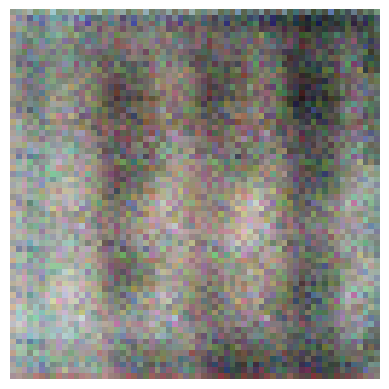

Transposed image shape: (64, 64, 3)


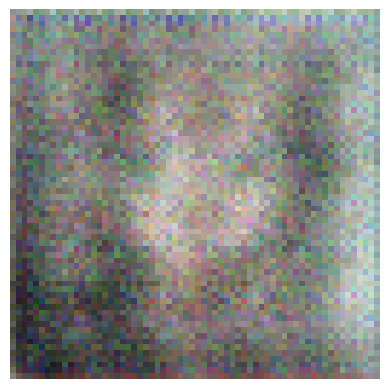

Transposed image shape: (64, 64, 3)


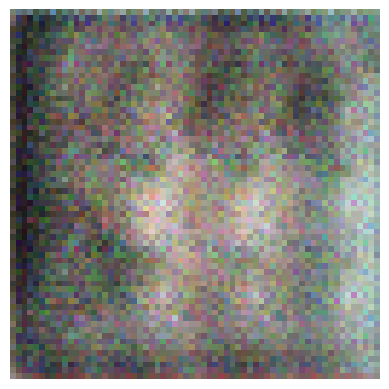

Transposed image shape: (64, 64, 3)


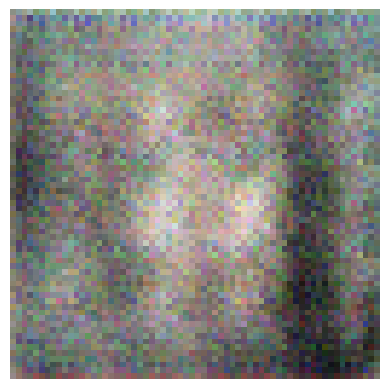

Transposed image shape: (64, 64, 3)


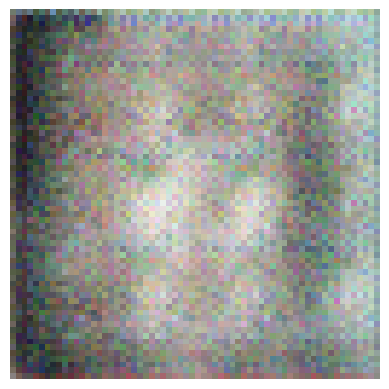

Transposed image shape: (64, 64, 3)


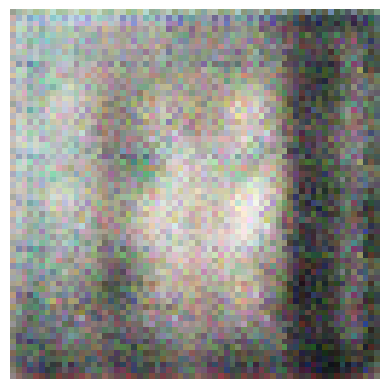

Transposed image shape: (64, 64, 3)


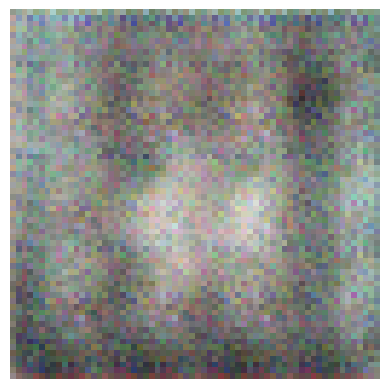

Transposed image shape: (64, 64, 3)


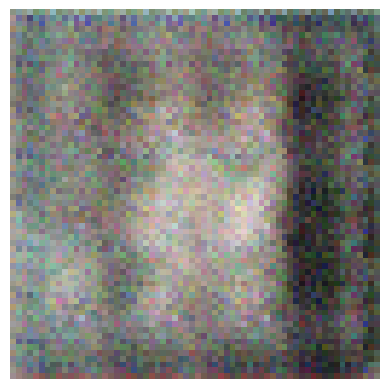

Transposed image shape: (64, 64, 3)


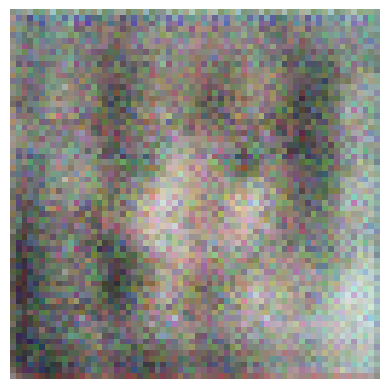

Transposed image shape: (64, 64, 3)


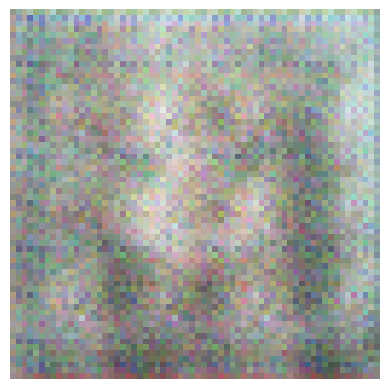

Transposed image shape: (64, 64, 3)


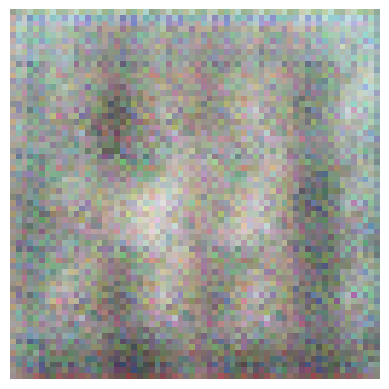

Transposed image shape: (64, 64, 3)


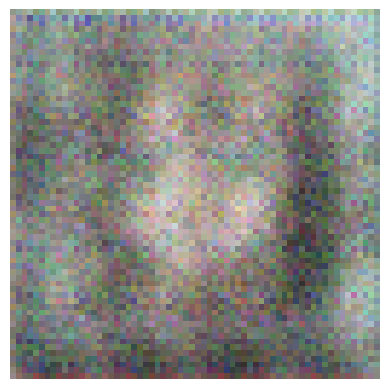

Transposed image shape: (64, 64, 3)


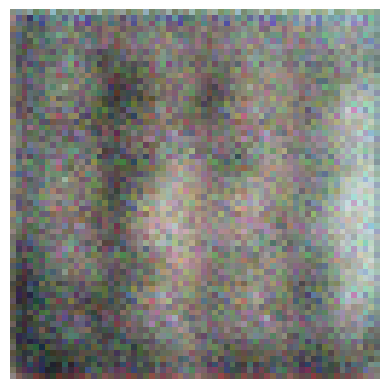

Transposed image shape: (64, 64, 3)


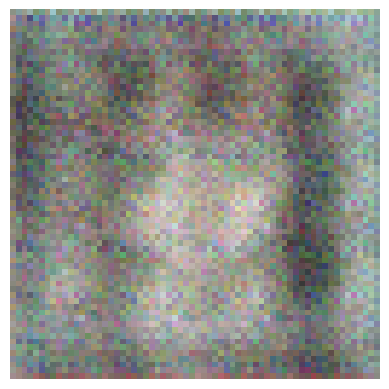

Transposed image shape: (64, 64, 3)


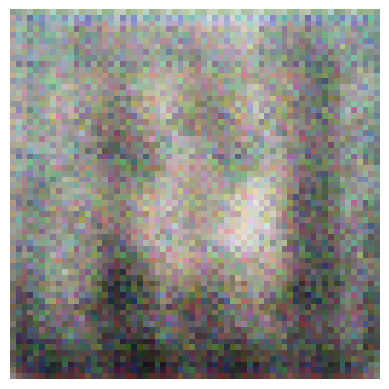

Transposed image shape: (64, 64, 3)


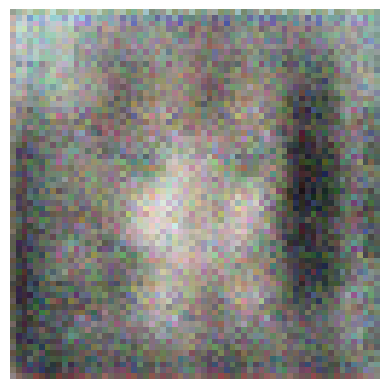

Transposed image shape: (64, 64, 3)


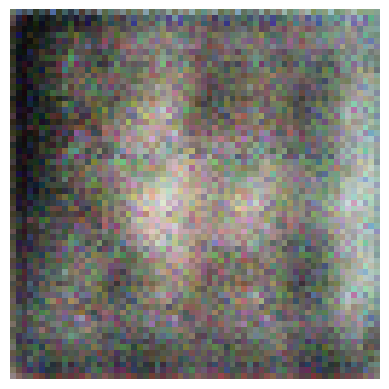

Transposed image shape: (64, 64, 3)


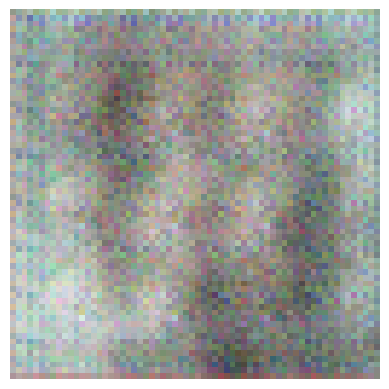

Transposed image shape: (64, 64, 3)


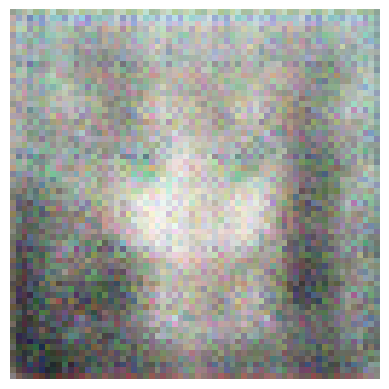

Transposed image shape: (64, 64, 3)


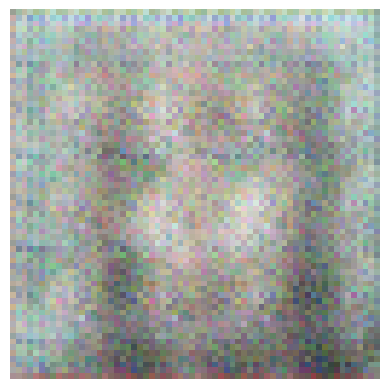

In [45]:
print(image_data.shape)

# Loop through each image in the batch and plot it individually
for i in range(image_data.shape[0]):
    transposed_image = image_data[i].transpose(1, 2, 0)
    print("Transposed image shape:", transposed_image.shape)
    plt.imshow(transposed_image)
    plt.axis('off')  # To not display axis
    plt.show()

Insufficient training time can lead to blurry images. Training the GAN for more epochs or increasing the dataset size can help improve the quality of generated images.

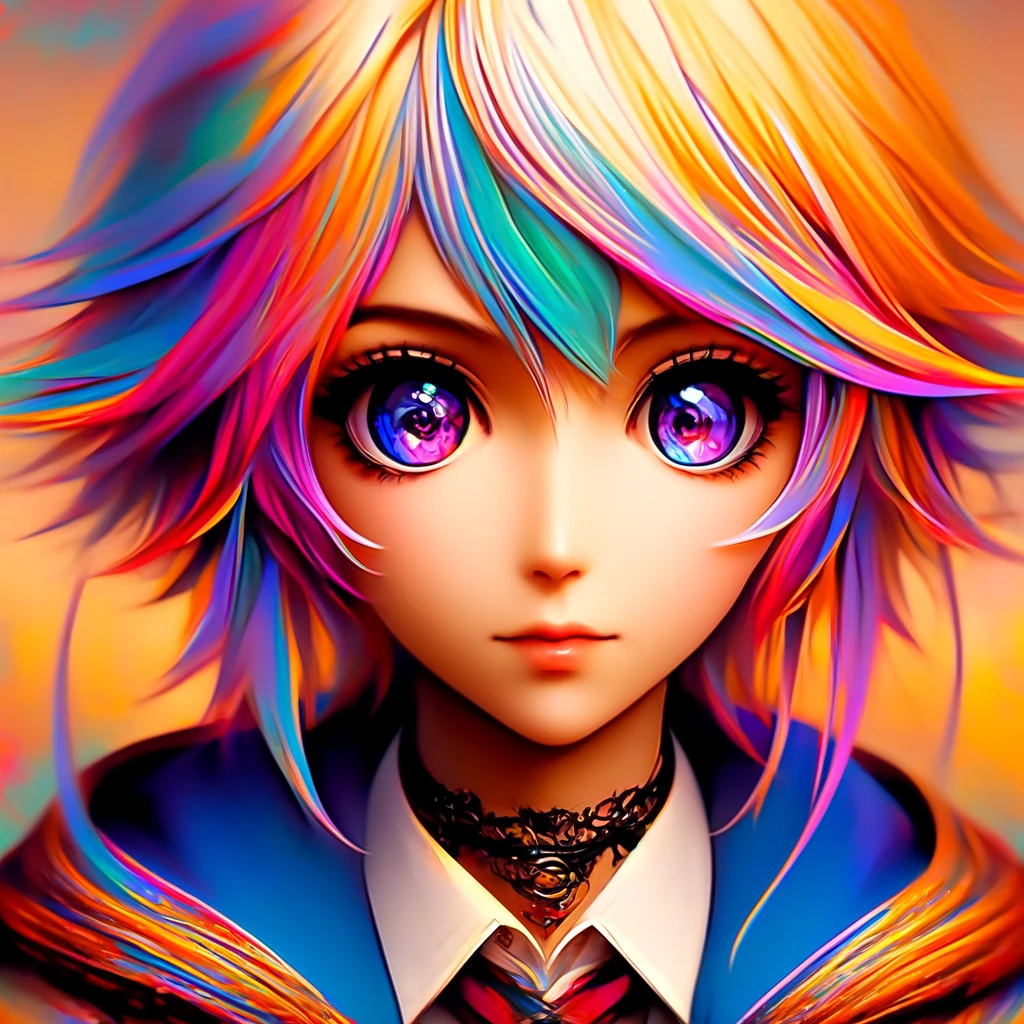

# **Conclusion**

Notebook emphasizes the effectiveness of Generative Adversarial Networks in generating visually appealing anime-style images, demonstrating significant potential for artificial intelligence in creative fields. Despite the achievements, the notebook identifies ongoing challenges like model stability and the need for refinement to produce more diverse and higher-quality images. This work encourages further exploration and development in GAN applications, suggesting that continued innovation could lead to remarkable advancements in digital art creation

**References :**

https://www.altexsoft.com/blog/generative-ai/

https://github.com/znxlwm/UGATIT-pytorch

https://www.kaggle.com/datasets/arnaud58/selfie2anime



**License**

Copyright 2024 Mrunali Pawar

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.